# Example - Hybrid Real/synthetic Electronics Data

In [1]:
import os
import sys
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch

sys.path.append('../src')
# import deepymod_torch.VE_params as VE_params
# import deepymod_torch.VE_datagen as VE_datagen
import VE_params
# from deepymod_torch.DeepMod import run_deepmod
# from deepymod_torch.library_functions import mech_library_real

# random seeding
np_seed = 2
torch_seed = 0
np.random.seed(np_seed)
torch.manual_seed(torch_seed)

In [2]:
# general_path = 'Oscilloscope data CRI electronics analogy/'
# specific_path = 'AWG 7V half sinc KELVIN 1 cap/' # It is precisely here that changes the data we are grabbing to test.
# path = general_path + specific_path

# Some of these factors are just for saving at the end but...
# ... omega is used in time scaling.
# ... mech_model is used to predict coeffs and recover mech params
input_type = 'Strain'
mech_model = 'GKM'
func_desc = 'Half Sinc'
omega = np.pi
Amp = 7
input_expr = lambda t: Amp*np.sin(omega*t)/(omega*t)
input_torch_lambda = lambda t: Amp*torch.sin(omega*t)/(omega*t)

# channel_1_data = np.loadtxt(path+'Channel 1 total voltage.csv', delimiter=',', skiprows=3)
# channel_2_data = np.loadtxt(path+'Channel 2 voltage shunt resistor.csv', delimiter=',', skiprows=3)

channel_1_data = np.loadtxt('Channel 1 total voltage.csv', delimiter=',', skiprows=3)
channel_2_data = np.loadtxt('Channel 2 voltage shunt resistor.csv', delimiter=',', skiprows=3)

The data contains a 'dead' period at the beginning before the voltage manipulation began, and then restarts the manipulation later on. We do not need to keep this data as it provides very little new information and makes the data significantly harder to fit. Below, by plotting the voltage data and tweaking the start and end points, we can isolate the interesting data.

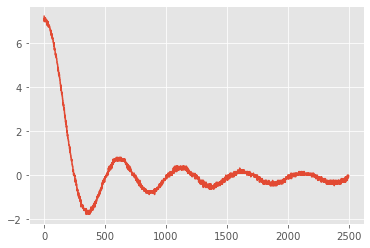

In [3]:
plt.plot(channel_1_data[806:3305, 1])

In [4]:
lower = 806
upper = 3305

voltage_array = channel_1_data[lower:upper, 1:]
voltage_shunt_array = channel_2_data[lower:upper, 1:]
time_array = channel_1_data[lower:upper, :1]

voltage_array = input_expr(time_array-min(time_array) + 10**-10)

r_0 = 1.99e3 # measured using multimeter
r_1 = 1.99e3 # measured using multimeter
r_2 = 1.99e3 # measured using multimeter

equiv_E = [1/r_0, 1/r_1]
equiv_eta = [1e-3]

current_array = voltage_shunt_array/r_shunt

## Overide voltage for calculated sinc curve

In [5]:
voltage_array = input_expr(time_array-min(time_array) + 10**-10)

In [6]:
# voltage_array = channel_1_data[:, 1:]
# voltage_shunt_array = channel_2_data[:, 1:]
# time_array = channel_1_data[:, :1]

Here I record the measured resistance values made with the multimeter. The values r_0, r_1, r_2 are only used to make predictions on the expected coefficients. r_shunt more critically is used to convert the voltage measured across the shunt resistor to the current through both it, and the whole mech model block.

In [7]:
r_0 = 1.99e3 # measured using multimeter
r_1 = 1.99e3 # measured using multimeter
r_2 = 1.99e3 # measured using multimeter

equiv_E = [1/r_0, 1/r_1]
equiv_eta = [1e-3]

In [8]:
# Maxwell shunt
r_shunt = 10.2 # measured using multimeter
# Kelvin shunt
# r_shunt = 10.5 # measured using multimeter

current_array = voltage_shunt_array/r_shunt

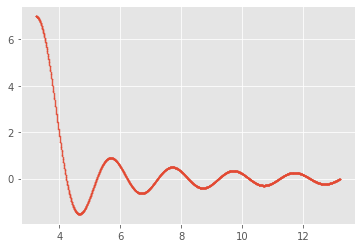

In [9]:
plt.plot(time_array, voltage_array, label='voltage', linestyle='None', marker='.', markersize=1)

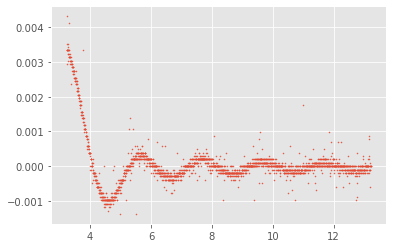

In [10]:
plt.plot(time_array, current_array, label='current', linestyle='None', marker='.', markersize=1)

## Data Treatment

In [11]:
# 'normalising'
t_sf = omega/1.2 # Aim for this to be such that the T of the scaled data is a bit less than 2pi
V_sf = 1/np.max(abs(voltage_array))
I_sf = 1/np.max(abs(current_array))
scaled_time_array = time_array*t_sf
scaled_voltage = voltage_array*V_sf
scaled_current = current_array*I_sf

# scaled_input_expr = lambda t: V_sf*input_expr(t/t_sf)
scaled_input_torch_lambda = lambda t: V_sf*input_torch_lambda(t/t_sf)
# scaled_voltage = scaled_input_expr(time_array-min(time_array) + 10**-10)

# structuring
target_array = np.concatenate((scaled_voltage, scaled_current), axis=1)

In [12]:
# random sampling
number_of_samples = 1000

reordered_row_indices = np.random.permutation(scaled_time_array.size)
reduced_time_array = scaled_time_array[reordered_row_indices, :][:number_of_samples]
reduced_target_array = target_array[reordered_row_indices, :][:number_of_samples]

## Predicting coefficients

First of all, we can forget that our problem has scaled data and do two things. First, remember that while capacitance is equivalent to viscosity, reistance is equivalent to the reciprocal of the elastic modulus. Second, we can put these viscosities and resistances into the function for calculating the expected coefficients. Intuitively for once, we interpret the model params as desribing a maxwell model. We do this because it was a Maxwell type model that we constructed on the breadboard, and so the parameters must be combined in a maxwell type fashion to return the equation coefficients.

In [13]:
pre_scaled_coeff_guess = VE_params.coeffs_from_model_params(equiv_E, equiv_eta, mech_model)
pre_scaled_coeff_guess

[0.502512562814070, 2000.00000000000, 1990.00000000000]

Thanks to our scaling, the coefficients we are going to discover here are actually also scaled compared to the coefficients as they would have been if no scaling had taken place. This is because we have two dependant quantities that have been scaled differently. If it had been just one scale factor, the coefficients would have been the same.

The LHS of the equation, the first time derivative of voltage, has been scaled the same way as any other voltage term. As a result, the coefficient(s) for voltage term(s) will already be scaled correctly.  This is because, although the voltage seen by DeepMoD is 10x lower than in reality, this would only need to be balanced by a coeffient 10x higher if the total of the RHS (the LHS) hadn't also been made 10x lower. As the coeffient of the LHS is always one, and the time derivative is now 10x smaller, all terms on the RHS should also be 10x smaller than before. A coefficient on the voltage term remaining that is also 10x smaller is unnecessary, as the voltage is already 10x smaller.

However, for the current terms, they will all be 100x bigger, due to scaling, so the coeffients must be 1000x smaller than an unscaled set of coeffs to preserve each coeff\*term product as being 10x smaller than before scaling, to match the LHS.

In summary, we need to take the current coeffients and divide them by 1000 to predict the coeffients as they will be for the normalised data.

The formula for scaling each cofficient is thus:

$$
c_n = C_n\frac{\alpha_{LHS}}{\alpha_n}
$$

where $C_n$ is the true coeffient for the nth term, $c_n$ is the scaled version that DeepMoD will find, $\alpha_n$ is the scale factor that was applied to the dependant quantity in term n, and $\alpha_{LHS}$ is the scale factor that was applied to the dependant quantity put on the LHS. 

In [14]:
scaled_coeff_guess = VE_params.scaled_coeffs_from_true(pre_scaled_coeff_guess, t_sf, V_sf, I_sf)
scaled_coeff_guess

[0.191945660010326, 0.470777646792833, 1.22633053221288]

## DeepMod prep

Transform into tensors for use by pytorch

In [15]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
target_tensor = torch.tensor(reduced_target_array, dtype=torch.float32)

## Defining Library

In [16]:
from torch.autograd import grad

# def mech_library_real(inputs, **library_config):    
    
#     prediction, data = inputs
    
#     # The first column of prediction is always strain
#     strain_derivs = auto_deriv(data, prediction[:, :1], library_config)
#     strain_theta = torch.cat((prediction[:, :1], strain_derivs), dim=1)
    
#     # The second column is always stress
#     stress_derivs = auto_deriv(data, prediction[:, 1:], library_config)
#     stress_theta = torch.cat((prediction[:, 1:], stress_derivs), dim=1)
    
#     strain_t = strain_theta[:, 1:2] # Extract the first time derivative of strain
#     strain_theta = torch.cat((strain_theta[:, 0:1], strain_theta[:, 2:]), dim=1) # remove this before it gets put into theta
#     strain_theta *= -1 # The coefficient of all strain terms will always be negative. rather than hoping deepmod will find these negative terms, we assume the negative factor here and later on DeepMoD will just find positive coefficients
#     theta = torch.cat((strain_theta, stress_theta), dim=1) # I have arbitrarily set the convention of making Strain the first columns of data
    
#     return [strain_t], theta


def mech_library(inputs, **library_config):    
    
    prediction, data = inputs
    
    input_theta = library_config['input_theta']
    if data.shape[0] == 1: # Swaps real input_theta out for dummy in initialisation pass.
        input_theta = torch.ones((1, input_theta.shape[1]))
    
    # Next use the result of the feedforward pass of the NN to calculate derivatives of your prediction with respect to time. 
    output_derivs = auto_deriv(data, prediction, library_config['diff_order'])
    output_theta = torch.cat((prediction, output_derivs), dim=1)
    
    # Next identify the input/output as Stress/Strain and organise into returned variables
    input_type = library_config['input_type']
    if input_type == 'Strain':
        strain = input_theta
        stress = output_theta
    elif input_type == 'Stress':
        strain = output_theta
        stress = input_theta
    else:
        print('Improper description of input choice. Was: '+input_type+'. Should be either \'Strain\' or \'Stress\'')
        
    strain_t = strain[:, 1:2] # Extract the first time derivative of strain
    strain = torch.cat((strain[:, 0:1], strain[:, 2:]), dim=1) # remove this before it gets put into theta
    strain *= -1 # The coefficient of all strain terms will always be negative. rather than hoping deepmod will find these negative terms, we assume the negative factor here and later on DeepMoD will just find positive coefficients
    theta = torch.cat((strain, stress), dim=1) # I have arbitrarily set the convention of making Strain the first columns of data
    
    return [strain_t], theta


def auto_deriv(data, prediction, max_order):
    '''
    data and prediction must be single columned tensors.
    If it is desired to calculate the derivatives of different predictions wrt different data, this function must be called multiple times.
    This function does not return a column with the zeroth derivative (the prediction).
    '''
    
    # First derivative builds off prediction.
    derivs = grad(prediction, data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]
    for _ in range(max_order-1):
        # Higher derivatives chain derivatives from first derivative.
        derivs = torch.cat((derivs, grad(derivs[:, -1:], data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]), dim=1)
                
    return derivs

#### Manipulation derivative library pre-calculation

In [17]:
library_diff_order = 1

input_data = scaled_input_torch_lambda(time_tensor)
input_derivs = auto_deriv(time_tensor, input_data, library_diff_order)
input_theta = torch.cat((input_data.detach(), input_derivs.detach()), dim=1)

In [18]:
library_config = {'diff_order': library_diff_order,
                  'input_type': input_type,
                  'input_theta': input_theta}

> THIS IS THE BREAK POINT FOR NOW. Below relies to heavily on src code changes or wrapper to send immediately. I'll work on that now.

It will be necessary to make the import statements for deepmod class etc here